Problem Statement -

Build your own recommendation system for products on an e-commerce website like Amazon.com.

Dataset columns - first three columns are userId, productId, and ratings and the fourth column is timestamp. You can discard the timestamp column as in this case you may not need to use it.

Please do the analysis based on steps( 1 to 8) as given below -

Steps -

1. Read and explore the given dataset.  ( Rename column/add headers, plot histograms, find data characteristics)
2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings )
3. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)
4. Build Popularity Recommender model.
5. Build Collaborative Filtering model.
6. Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)
7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.
8. Summarise your insights.

In [3]:
# importing libraries
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

##### 1. Read and explore the given dataset.  ( Rename column/add headers, plot histograms, find data characteristics)**

In [5]:
# load the dataset
colnames = ["UserID", "ProductID", "Rating", "Timestamp"]
Ratings_df = pd.read_csv("ratings_Electronics.csv")
Ratings_df.columns = colnames

In [7]:
Ratings_df.shape

(7824481, 4)

In [8]:
Ratings_df.head()

,UserID,ProductID,Rating,Timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [9]:
# drop "Timestamp" as it is not used in recommendation
Ratings_df.drop(['Timestamp'],axis=1,inplace=True)

In [10]:
Ratings_df.head()

,UserID,ProductID,Rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [11]:
Ratings_df.dtypes

UserID        object
ProductID     object
Rating       float64
dtype: object

**Missing Value Treatment**

In [12]:
# check missing values.
Ratings_df.isnull().sum()

UserID       0
ProductID    0
Rating       0
dtype: int64

None of the records have missing values

**Visual identification - Histogram**

In [13]:
# utilify function for % distribution
def category_distribution(df, colname):
    col_data = df[colname].value_counts().to_frame()
    col_data.reset_index(inplace=True)
    col_data.columns = [col_data.columns[1], 'count']
    col_data['proportions'] = col_data['count'] / sum(col_data['count'])
    print("\n % Distribution for: ",colname)
    print(col_data)
    return

In [14]:
# numbers of unique users
print("Unique users: ", len(Ratings_df.UserID.unique()))

# numbers of unique products
print("Unique Products ", len(Ratings_df.ProductID.unique()))

Unique users:  4201696
Unique Products  476001


In [15]:
Ratings_df.Rating.value_counts()

5.0    4347540
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: Rating, dtype: int64

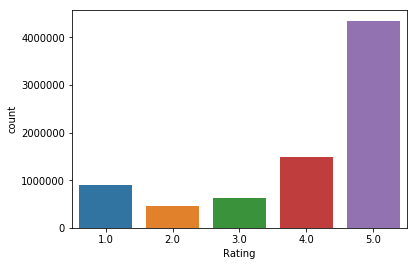

In [16]:
# plotting count of Rating
sns.countplot(data=Ratings_df , x='Rating')
plt.show()

In [17]:
# analysising % distribution of Rating columns
category_distribution(Ratings_df, "Rating")


 % Distribution for:  Rating
   Rating    count  proportions
0     5.0  4347540     0.555633
1     4.0  1485781     0.189889
2     1.0   901765     0.115249
3     3.0   633073     0.080909
4     2.0   456322     0.058320


**Observation on Rating distribution**

It has been observed that rating 1,2,3 and 4 are most common amongst users and rating 5 has been given highest number of times. Infact rating 5 covers approx 55% of dataset.

**Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings )**

In [18]:
# For more accurate results only consider users who have rated atleast 50 number of ratings

counts = Ratings_df['UserID'].value_counts()
ratings_explicit_df = Ratings_df[Ratings_df['UserID'].isin(counts[counts >= 50].index)]

In [19]:
ratings_explicit_df.head()

,UserID,ProductID,Rating
93,A3BY5KCNQZXV5U,0594451647,5.0
117,AT09WGFUM934H,0594481813,3.0
176,A32HSNCNPRUMTR,0970407998,1.0
177,A17HMM1M7T9PJ1,0970407998,4.0
491,A3CLWR1UUZT6TG,0972683275,5.0


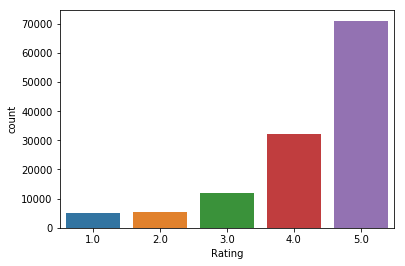

In [20]:
# plotting count of Rating
sns.countplot(data=ratings_explicit_df , x='Rating')
plt.show()

In [21]:
# analysising % distribution of Rating columns of new dataset
category_distribution(ratings_explicit_df, "Rating")


 % Distribution for:  Rating
   Rating  count  proportions
0     5.0  71034     0.564340
1     4.0  32295     0.256572
2     3.0  12060     0.095812
3     2.0   5367     0.042639
4     1.0   5115     0.040637


In [22]:
ratings_explicit_df.shape

(125871, 3)

In [23]:
# numbers of unique users
print("Unique users: ", len(ratings_explicit_df.UserID.unique()))

# numbers of unique products
print("Unique Products ", len(ratings_explicit_df.ProductID.unique()))

Unique users:  1540
Unique Products  48190


**Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)**

In [24]:
from sklearn.model_selection import train_test_split

trainDF, tempDF = train_test_split(ratings_explicit_df, test_size=0.3, random_state=100)


# we need to ensure that user in test data shall be avaiable in training data set for recomendation.
# for this we will copy the test dataset and make that user rating as np.nan

# 
#creating a copy of tempDF as testDF
testDF = tempDF.copy()

#Assigning ratings of tempDF to nan
tempDF.Rating = np.nan

#Creating ratings with trainDF and tempDF
df_ratings = pd.concat([trainDF, tempDF])
print("Shape:" ,df_ratings.shape)
df_ratings.head()

Shape: (125871, 3)


,UserID,ProductID,Rating
5993537,ANW6EGY12V5XS,B007ZW43IQ,4.0
4459174,A1QVFHPY8418HC,B004T9Y0MW,5.0
2177399,ALDAF4VVLFRHP,B001NOG2T0,4.0
232286,A11YIHB6IW352W,B00007KDVI,5.0
7811982,A3PD8JD9L4WEII,B00JGSWU7S,5.0


**Build Popularity Recommender model.**

In [25]:
# making format of ratings matrix to be one row per user and one column per product. 
# Fill not available values as 0.0 - sprase martix
# since NaNs cannot be handled by training algorithms, replacing these by 0, which indicates absence of ratings
ratings_matrix = df_ratings.pivot(index = 'UserID', columns ='ProductID', values = 'Rating').fillna(0)
userID = ratings_matrix.index
productID = ratings_matrix.columns
ratings_matrix.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# Normalize the ratings using StandardScaler
scaler = StandardScaler()
ratings_matrix_std = scaler.fit_transform(ratings_matrix)

In [27]:
# Consider all the mean ratings of each product and find the product with highest mean value
# display the top 10 ProductIDs.
df_mean = pd.DataFrame(ratings_matrix_std).mean(axis=0)
mean_df_sorted = df_mean.sort_values(ascending=False)
mean_df_sorted.head() # this diaplay column index for the product with popularity

43781    1.611346e-15
45997    1.564387e-15
17759    1.554970e-15
40014    1.509858e-15
42201    1.445318e-15
dtype: float64

In [28]:
# lets display the top 10 product with thier "ProductID" and rating
df_porpularity = pd.DataFrame({"ProductID": productID[mean_df_sorted.index], "MeanRating": mean_df_sorted.values})

In [29]:
print("\nPopularity model with overall top 10 products: ")
df_porpularity.head(10)


Popularity model with overall top 10 products: 


,MeanRating,ProductID
0,1.611346e-15,B00BW6LW7G
1,1.564387e-15,B00F0DCH9Y
2,1.554970e-15,B001LNO722
3,1.509858e-15,B008R91OZ6
4,1.445318e-15,B00AA478UQ
5,1.436090e-15,B00EVWX5UK
6,1.409262e-15,B004YLAYHA
7,1.403936e-15,B004VVLZY4
8,1.392185e-15,B007K3SB6K
9,1.381867e-15,B00068YUN4


**df_porpularity: this contains top recommended products in order based on mean rating**

In [30]:
# Get top 10 recommendations for user not already rated by that user
# This is because there no need to recomend same product to the user if it is already seen by the user.
def pm_recommend(pop_model, dataset, userid, k=5):
    user_product = dataset[dataset.UserID == userid]
    print ('User {0} has already rated {1} movies.'.format(userid, user_product.shape[0]))
    user_rec = pop_model[~pop_model["ProductID"].isin(user_product["ProductID"])]
    return user_rec.head(k)

**Use the popularity model to make some predictions for the user**

 Get top 10 recommendations for user not already rated by that user

In [31]:
num_recommendations = 10
userid = userID[0]

#  Get top 10 recommendations for user not already rated by that user
user_rec = pm_recommend(df_porpularity, df_ratings, userid, 10)

print("Top %d recomendation for user: %s" %(num_recommendations, userid))
print(user_rec)

User A100UD67AHFODS has already rated 116 movies.
Top 10 recomendation for user: A100UD67AHFODS
     MeanRating   ProductID
0  1.611346e-15  B00BW6LW7G
1  1.564387e-15  B00F0DCH9Y
2  1.554970e-15  B001LNO722
3  1.509858e-15  B008R91OZ6
4  1.445318e-15  B00AA478UQ
5  1.436090e-15  B00EVWX5UK
6  1.409262e-15  B004YLAYHA
7  1.403936e-15  B004VVLZY4
8  1.392185e-15  B007K3SB6K
9  1.381867e-15  B00068YUN4


**Build Collaborative Filtering model.**

In [32]:
# making format of ratings matrix to be one row per user and one column per product. 
# Fill not available values as 0.0 - sprase martix
# since NaNs cannot be handled by training algorithms, replacing these by 0, which indicates absence of ratings
ratings_matrix = df_ratings.pivot(index = 'UserID', columns ='ProductID', values = 'Rating').fillna(0)
userID = ratings_matrix.index
productID = ratings_matrix.columns
print("Shape: ", ratings_matrix.shape)
ratings_matrix.head()

Shape:  (1540, 48190)


ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
print("ratings_matrix Shape: ", ratings_matrix.shape)

ratings_matrix Shape:  (1540, 48190)


In [34]:
from scipy.sparse.linalg import svds
# singluar value decomposition
# Compute the largest k singular values/vectors for a sparse matrix.
# k: Number of singular values and vectors to compute. Must be 1 <= k < min(rating_matrix.shape)
# rating_matrix is to compute the SVD on
# The singular values - sigma
U, sigma, Vt = svds(ratings_matrix, k = 50)

In [35]:
print("U shape: ", U.shape)
print("sigma shape: ", sigma.shape)
print("Vt shape: ", Vt.shape)

U shape:  (1540, 50)
sigma shape:  (50,)
Vt shape:  (50, 48190)


In [36]:
sigma = np.diag(sigma)

# also need to add the user means back to get the predicted ratings
# np.dot - Dot product of two arrays
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = ratings_matrix.columns)

In [37]:
#predictions of product ratings
preds_df.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.0,0.001709,0.024331,0.005945,0.004351,0.010768,0.010768,0.001923,0.008695,0.008446,...,0.001809,-0.041331,0.004726,0.007982,0.051230,0.008768,0.000362,-0.051972,0.0,0.0
1,0.0,-0.007123,-0.006289,0.120423,0.005043,-0.000187,-0.000187,-0.000186,0.036104,0.000422,...,0.000579,0.015339,-0.007341,-0.015440,-0.087229,-0.003496,0.005618,-0.037100,0.0,0.0
2,0.0,-0.004448,-0.004503,0.055088,0.010973,-0.003907,-0.003907,0.005015,-0.002699,-0.002317,...,-0.001212,-0.015249,0.000867,-0.058683,0.014585,-0.006548,-0.002190,0.053129,0.0,0.0
3,0.0,0.009681,0.000403,-0.012862,0.000396,0.001885,0.001885,-0.002139,0.000982,0.001151,...,0.000046,-0.035728,0.000947,-0.033231,-0.009888,0.004529,0.002712,-0.015924,0.0,0.0
4,0.0,-0.000742,0.000242,0.060081,0.009237,0.000323,0.000323,0.001800,-0.001339,0.001406,...,0.000731,0.039402,0.001625,0.025449,-0.038492,-0.001391,-0.000709,0.053937,0.0,0.0


In [38]:
preds_df.shape

(1540, 48190)

In [39]:
def cf_recommend(cb_model, dataset, userid, users, k=5):
    # get the row number from userid
    user_row_number = users.get_loc(userid)    
    # Get and sort the user's predictions
    sorted_user_predictions = cb_model.iloc[user_row_number].sort_values(ascending=False)
    df_sorted_user_pred = pd.DataFrame(sorted_user_predictions).reset_index() 
    df_sorted_user_pred.rename(columns={user_row_number: "Prediction"}, inplace=True)
    user_product = dataset[dataset.UserID == userid]## list of product already rated by users
    print ('User {0} has already rated {1} movies.'.format(userid, user_product.shape[0]))
    user_rec = df_sorted_user_pred[~df_sorted_user_pred["ProductID"].isin(user_product["ProductID"])]
    return user_rec.head(k)

In [40]:
num_recommendations = 10
userid = userID[0]

#  Get top 10 recommendations for user not already rated by that user
user_rec = cf_recommend(preds_df, df_ratings, userid, userID, num_recommendations)

print("Top %d recomendation for user: %s" %(num_recommendations, userid))
print(user_rec)

User A100UD67AHFODS has already rated 116 movies.
Top 10 recomendation for user: A100UD67AHFODS
     ProductID  Prediction
1   B002V88HFE    0.831290
3   B0019EHU8G    0.746761
4   B001E1Y5O6    0.737800
6   B000JMJWV2    0.651649
10  B0079TOEQQ    0.539850
11  B00CMJZAOI    0.539118
12  B007I5JT4S    0.525738
13  B004CLYEFK    0.524209
14  B005DKZTMG    0.519649
15  B003ES5ZUU    0.506974


### 6. Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)

**Evaluate Popularity model: calculating RSME on test data**

In [41]:
# Temporary dataframe for predicting rating of each user and its product for test cases
df_final_pm = testDF.copy(deep=True)
df_final_pm["MeanRating"] = 0
df_final_pm.head()

,UserID,ProductID,Rating,MeanRating
3071496,AWH2AY17ZU7W2,B0035JCI6M,3.0,0
1270451,A2MSBIA18RXYQC,B000P1711K,1.0,0
1506248,A1H98YV5K5BUX0,B000WZ7Y5C,5.0,0
7709305,A2X8KN82L07RSK,B00GO4GMAI,5.0,0
2570182,AU627A4UGIW6V,B002EPF6YO,4.0,0


In [42]:
# get mean rating for product - Popularity model
# pm_model: contains predicted rating all products
# productid: product name for which predited rating is calculated
def pm_get_predicted_rating(pm_model, productid):
    rating = pm_model[pm_model.ProductID == productid].iloc[0,1]
    return rating

# finding predicted rating for user and its prodcut for test cases - colaboratibe filtering
def pm_transform_row(r):
    global df_porpularity
    r.MeanRating = pm_get_predicted_rating(df_porpularity, r.iloc[1])
    return r

In [43]:
df_final_pm = df_final_pm.apply(pm_transform_row, axis=1)
df_final_pm.head()

,UserID,ProductID,Rating,MeanRating
3071496,AWH2AY17ZU7W2,B0035JCI6M,3.0,B0035JCI6M
1270451,A2MSBIA18RXYQC,B000P1711K,1.0,B000P1711K
1506248,A1H98YV5K5BUX0,B000WZ7Y5C,5.0,B000WZ7Y5C
7709305,A2X8KN82L07RSK,B00GO4GMAI,5.0,B00GO4GMAI
2570182,AU627A4UGIW6V,B002EPF6YO,4.0,B002EPF6YO


In [44]:
import math

# Let calculate the RMSE
# calculating sum of squared errors for predicted and actual for test data 
mse = np.mean((df_final_pm["Rating"]-df_final_pm["MeanRating"])**2)

# underroot of mean_sq_error is standard deviation i.e. avg variance between predicted and actual
pm_rmse = math.sqrt(mse)

print("RMSE for Popularity model: ", pm_rmse)

TypeError: unsupported operand type(s) for -: 'float' and 'str'

**Evaluate Colaborative filtering model: calculating RSME on test data**

In [ ]:
# Temporary dataframe for predicting rating of each user and its product for test cases
df_final_cf = testDF.copy(deep=True)
df_final_cf["PredRating"] = 0
df_final_cf.head()

In [ ]:
# get rating for user and its product - Colaborative filtering
# df_model: contains predicted rating matrix for users and all products
# users: unique users for knowing its row indexs in df_model
# products: unique products for know it column indexs in df_model
# userid: user name
# productid: product name
def cf_get_predicted_rating(cf_model, users, products, userid, productid):
    user_row_number = users.get_loc(userid)
    product_col_number = products.get_loc(productid)
    rating = cf_model.iloc[user_row_number, product_col_number]
    return rating

# finding predicted rating for user and its prodcut for test cases - colaboratibe filtering
def cf_transform_row(r):
    global preds_df
    global userID
    r.PredRating = cf_get_predicted_rating(preds_df, userID, productID, r.iloc[0], r.iloc[1])
    return r

In [ ]:
df_final_cf = df_final_cf.apply(cf_transform_row, axis=1)

In [ ]:
df_final_cf.head()

In [ ]:
import math

# Let calculate the RMSE
# calculating sum of squared errors for predicted and actual for test data 
mse = np.mean((df_final_cf["Rating"]-df_final_cf["PredRating"])**2)

# underroot of mean_sq_error is standard deviation i.e. avg variance between predicted and actual
cf_rmse = math.sqrt(mse)

In [ ]:
print("RMSE for Popularity model: %0.4f" %(pm_rmse))
print("RMSE for Colaborative filtering model:  %0.4f" %(cf_rmse))

### 7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.

In [ ]:
num_recommendations = 5
userid_index = 4  # 0~1539 (there are 1540 unique users)
userid = userID[userid_index]

#  colaborative filtering: Get top 10 recommendations for user not already rated by that user
user_rec = cf_recommend(preds_df, df_ratings, userid, userID, num_recommendations)

print("Top %d recomendation for user: %s" %(num_recommendations, userid))
print(user_rec)

### 8. Summarise your insights.

After Evaluating accuracy by comparing the predicted ratings directly with the actual user rating using RMSE,
it is observed that Colaborative filtering model lead to lower RMSE than popularity model and hence better 
modle for this case study